# K-means clustering using MPI(Message Passing Interface API provided by Python mpi4py ) 

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity. 

## Choosing K
The algorithm described above finds the clusters and data set labels for a particular pre-chosen K. To find the number of clusters in the data, the user needs to run the K-means clustering algorithm for a range of K values and compare the results. In general, there is no method for determining exact value of K, but an accurate estimate can be obtained using the following techniques.

One of the metrics that is commonly used to compare results across different values of K is the mean distance between data points and their cluster centroid. Since increasing the number of clusters will always reduce the distance to data points, increasing K will always decrease this metric, to the extreme of reaching zero when K is the same as the number of data points. Thus, this metric cannot be used as the sole target. Instead, mean distance to the centroid as a function of K is plotted and the "elbow point," where the rate of decrease sharply shifts, can be used to roughly determine K.


## Elbow method 
As described above the elbow methos is used to pick the optimal k value. The idea of elbow method is to run k-means clustering on the dataset for a range of values of K(say k from 1 to 15) and for each value of K,calculate the sum of squared errors(SSE).
Then plot a line chart of the SSE for each value of k. If the chart look like an arm, then the elbow on the arm is the value of k that is best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

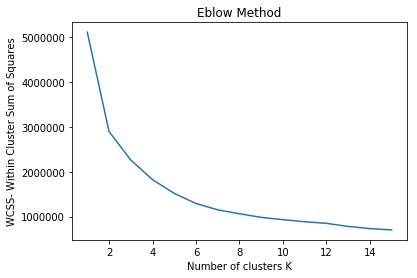

In [2]:
"""
Created on Mon Apr 30 09:33:54 2018
@author: John Robert
"""
import numpy as np 
import matplotlib.pyplot as plot 
import pandas as pd 
from sklearn.cluster import KMeans

#Importimg dataset
dataset = pd.read_csv("Absenteeism_at_work.csv", delimiter= ";")


#Using elbow method to get the best number of clusters - k 
#WGSS - Within Groups Sum of Squares
#wcss - within cluster sum of squares
wcss = []
for i in range(1,16):
    kmeans = KMeans(n_clusters = i, init ="k-means++", random_state = 0)
    kmeans.fit(dataset)
    
    #sum of the distances of samples to their closest cluster center
    wcss.append(kmeans.inertia_)
    
plot.plot(range(1,16),wcss)
plot.title('Eblow Method')
plot.xlabel('Number of clusters K')
plot.ylabel('WCSS- Within Cluster Sum of Squares')
plot.show()

#KMeans clustering 
kmeans = KMeans(n_clusters = 5, init = 'k-means++',random_state=0)
y = kmeans.fit_predict(dataset)

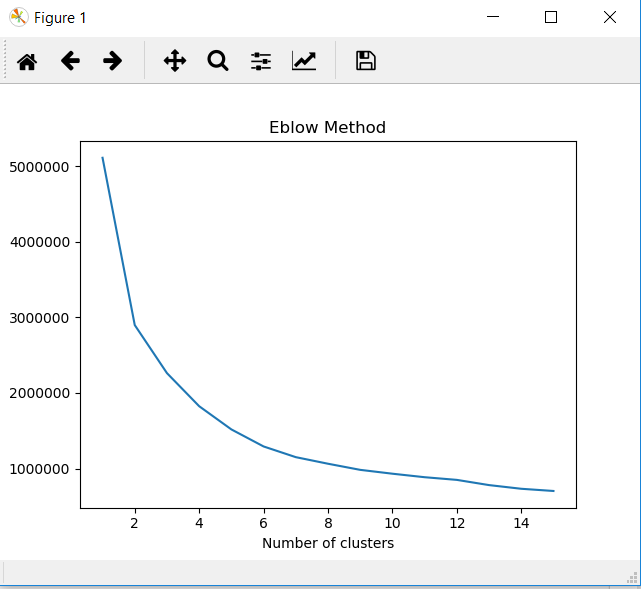

### Comment 
Best number of clusters for the dataset of Absenteeism_at_work.csv is 5

## Algorithm
The algorithm progress as:


    > Initialize K centroids
    > Divide Data instances among P workers 
    > Until converge:

        – step 1: Update Membership

            ∗ calculate distance of each Data instance from each centroid using the euclidean distance
            ∗ Assign membership of each data instance using the minimum distance in the distance matrix.

        – step 2: Update Centroids

            ∗ Each worker calculates the new centroids (local means) using the new membership of data instance
            ∗ collect updated centroids (local mean) information from each worker and find the global centroids
            ∗ redistribute new centroids of clusters to each worker.


 ## Strategy
1. Intialize the number of clusters/centroids - k  
2. Import the csv file 
3. When it is worker with ID 0 that is the root worker 
4. Randomly select K number of rows as the intial centroid, where k is the number of cluster we want 
5. Divide the rows of the matrix of the csv file by the number of workers 
6. Create an array containing each slice of data for each worker
7. Use the scatter collective communication so send each slice to their respective worker 

#### start the iteration of creating new centroid still the present centroid is equal to past centroid, every worker is involved in this process 

8. While the present centroid is not equal to the previous centroid do step 9 - 16
9. Find the distance between each point and each distance. Each point is a row in the matrix usind euckidean distance 
10. Find the closest centriod to each point 
11. Cluster the point based on the closest centroid to them 
12. Return send the cluster to the root worker 

###### Back to the root worker 

13. The root worker get the clusters made by all the workers 
14. Check all the point with the same cluster
15. Get the point with the point in the same cluster and find the average 
16. The average of each cluster becomes the the new centroid 
17. When the previous cluster is equal to the present cluster stop
18. The final cluster of each point will be the right cluster 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue May  1 23:25:37 2018

@author: John Robert
"""

from mpi4py import MPI
import numpy as np
from scipy.spatial import distance_matrix 
import matplotlib.pyplot as plot 
import pandas as pd 
from sklearn.cluster import KMeans

K = 6

df= pd.read_csv("Absenteeism_at_work.csv", delimiter= ";")
#print(dataset)

    
dataset =df.values
dataset = dataset.astype(int)

def k_means(X,K):
     
    t_start = MPI.Wtime()
    
    nrow = X.shape[0]
    ncol = X.shape[1]
    
    #Pick 4 random rows as the centroid 
    initial_centroids = np.random.choice(nrow,K,replace=False)
    #print("initial_centroids: {} \n".format(initial_centroids))
    
    #Get the details of each rows we pick as centroid
    centroids = X[initial_centroids]
    print("Fist Centroid centroids: \n {} \n".format(centroids))
    
    #Create a temp variable to store old centroid and old cluster for each point(rows)
    centroids_old = np.zeros((K,ncol))
    cluster_assignments = np.zeros(nrow)
    
    
    while (centroids_old != centroids).any():
        
        #To keep track of the change in centroid because the present centroid will be replaced
        centroids_old = centroids.copy()
        print("Present centroid: {} \n".format(centroids_old))
        #Compute distance between data points and centroids
        dist_matrix = distance_matrix(X,centroids, p=2)
        #print("dist_matrix: {} \n".format(dist_matrix))
        print("The distance of each centriod to each point \n {} \n".format(dist_matrix ))
        
        for i in np.arange(nrow):
            
            #To calculate the closest centriod for each row or point
            d = dist_matrix[i]
            closest_centroid = (np.where(d == np.min(d)))[0][0]
            
            cluster_assignments[i] = closest_centroid
            #print("Point {} is closest to {} to it is in cluster {}\n".format(i,closest_centroid,closest_centroid ))
            
            
        for k in np.arange(K):
            #Pick all the point in each K 
            Xk = dataset[ cluster_assignments == k]
            
            print("List of all point in cluster {} \n {} \n".format(k,Xk ))
            
            
            #Find the mean of all the point in each cluster 
            centroids[k] = np.apply_along_axis(np.mean,axis = 0, arr=Xk)
            #print("Xk: {} \n".format(Xk))
            
    t_diff = MPI.Wtime() - t_start
    return(centroids,cluster_assignments,t_diff)
    
k_means_result = k_means(dataset,K)

centriods = k_means_result[0]
cluster_assignemnts = (k_means_result[1]).tolist()
time_spent = k_means_result[2]
print("Final Centroid \n {} \n".format(centriods))
 
print("Final Cluster \n {} \n".format(cluster_assignemnts)) 

print("Total time taken {} \n".format(time_spent))


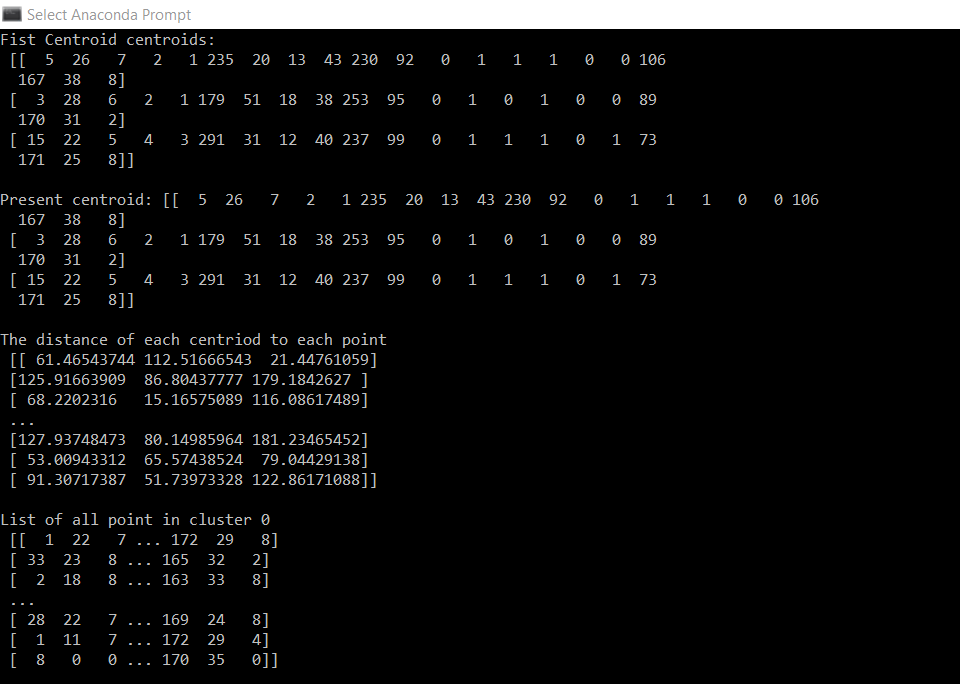

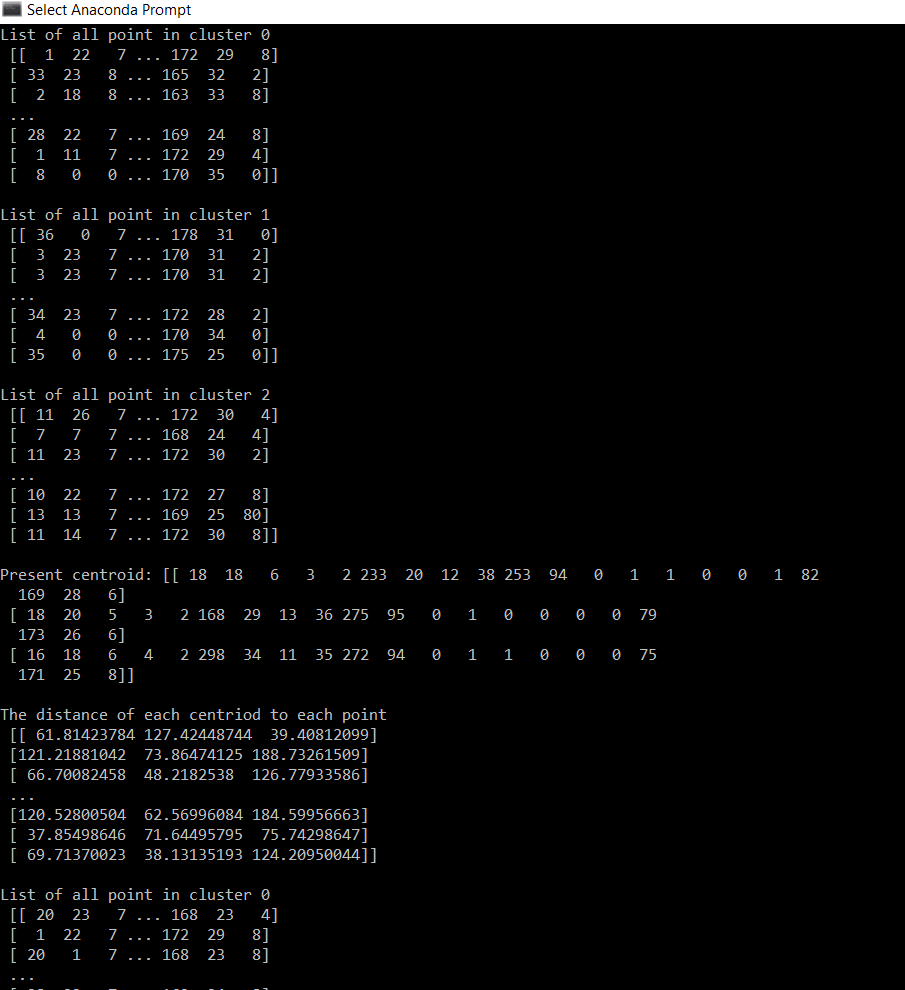

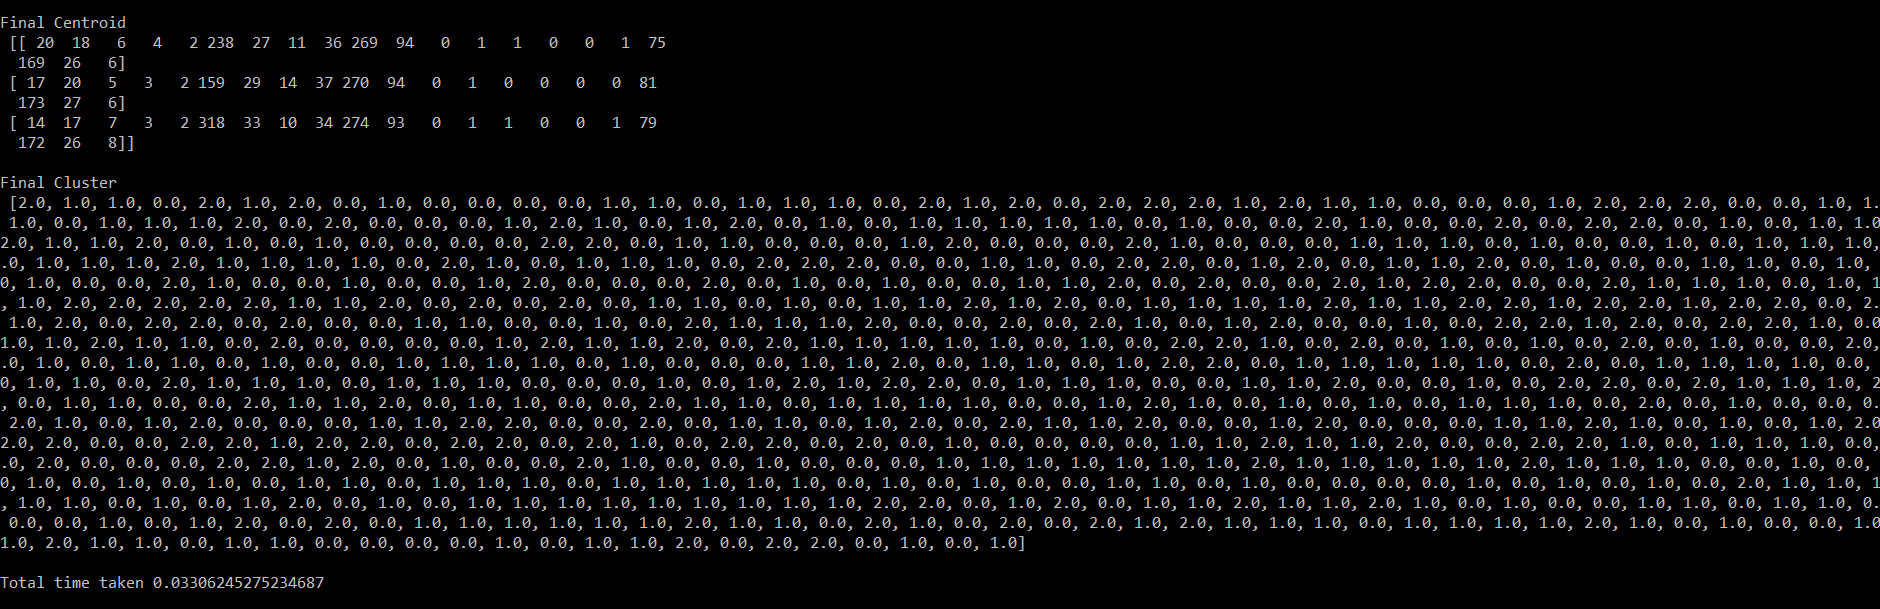

|                 | Number of Workers(processor)                                                        |            
|-----------------|---------------------------------------------------------------------------|
| Cluster         |1 = T1  |2 = T2 |  sp    | 3 = T3 |   sp  |4 = T4 |  sp   | 5 = T5|  sp
|-----------------|--------|-------|--------|--------|-------|-------|-------|-------|
| 2               | 0.0381 |0.0300 | 1.27   |0.0241  |1.5809 |0.0200 |1.9050 |0.0224 |1.7009   
| 3               | 0.0977 |0.0912 | 1.0712 |0.0876  |1.1152 |0.0792 |1.2336 |0.0845 |1.1562
| 4               | 0.1178 |0.1058 | 1.1134 |0.0956  |1.2322 |0.0946 |1.2452 |0.0967 |1.2182
| 5               | 0.1398 |0.1247 | 1.1210 |0.1200  |1.1650 |0.1125 |1.2427 |0.1198 |1.1669
| 6               | 0.2093 |0.1683 | 1.2536 |0.1568  |1.3348 |0.1484 |1.4103 |0.1267 |1.6519
| 8               | 0.2593 |0.2134 | 1.215  |0.2053  |1.2630 |0.1901 |1.3640 |0.2190 |1.1840

Speedup (Sp) is defined as the ratio of runtime for a sequential algorithm (T1) to runtime for a parallel algorithm with p processors (Tp). That is, $sp = \frac{T1}{Tp}$  

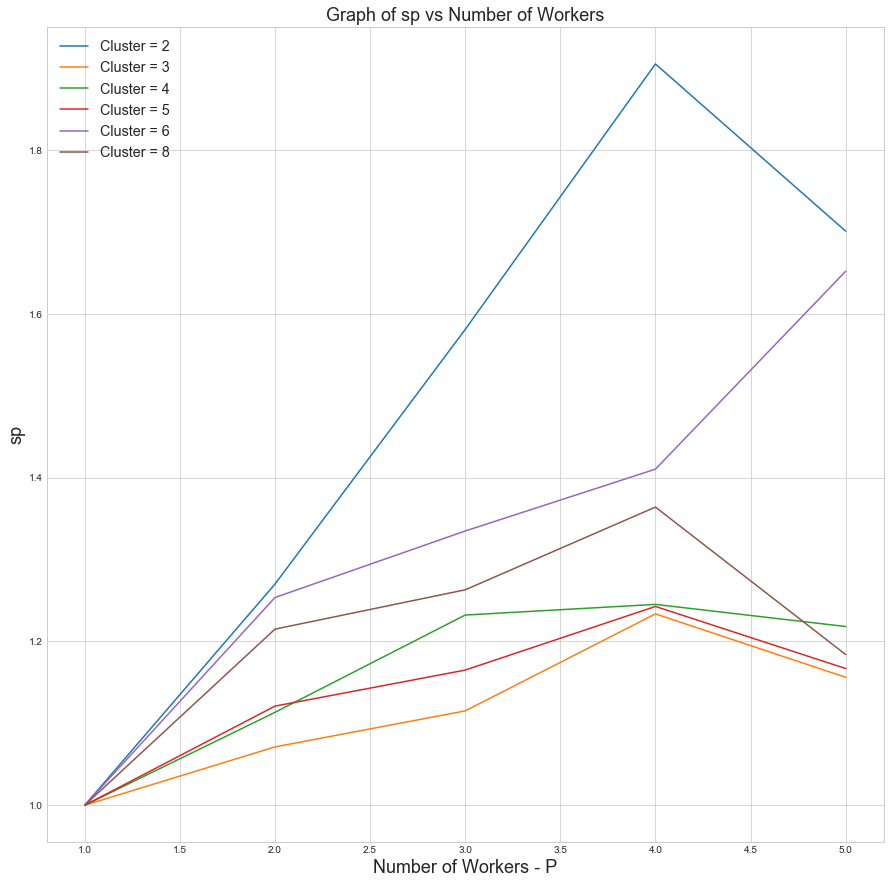

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,15)
sb.set_style ('whitegrid')

noWorkers  = [1,2,3,4,5]

sp4cluster2 = [1.0000, 1.2700, 1.5809, 1.9050,1.7009]
sp4cluster3 = [1.0000, 1.0712, 1.1152, 1.2336,1.1562]
sp4cluster4 = [1.0000, 1.1134, 1.2322, 1.2452,1.2182]
sp4cluster5 = [1.0000, 1.1210, 1.1650, 1.2427,1.1669]
sp4cluster6 = [1.0000, 1.2536, 1.3348, 1.4103,1.6519]
sp4cluster8 = [1.0000, 1.2150, 1.2630, 1.3640,1.1840]
 
plt.plot(noWorkers,sp4cluster2, label = "Cluster = 2" )
plt.plot(noWorkers,sp4cluster3, label = "Cluster = 3" )
plt.plot(noWorkers,sp4cluster4, label = "Cluster = 4" )
plt.plot(noWorkers,sp4cluster5, label = "Cluster = 5" )
plt.plot(noWorkers,sp4cluster6, label = "Cluster = 6" )
plt.plot(noWorkers,sp4cluster8, label = "Cluster = 8" )


plt.xlabel("Number of Workers - P", fontsize=18)
plt.ylabel("sp", fontsize=18)
plt.yticks()
plt.title('Graph of sp vs Number of Workers', fontsize=18)
plt.legend(fontsize='x-large')

### Comment 
Speedup is one of the main performance characteristics of distributed applications. It is usually defined as the ratio of application’s execution time on a single processor to the execution time, of the same workload, on a system composed on P processors.The speedup depends upon a number of factors which include the number of processors and their performances, the connections between the processors, the algorithm used for the distribution of the workload, etc
From the graph of the speedup above, we could see that the speedup of each process is averagely sub-linear speedup. The performance of is average

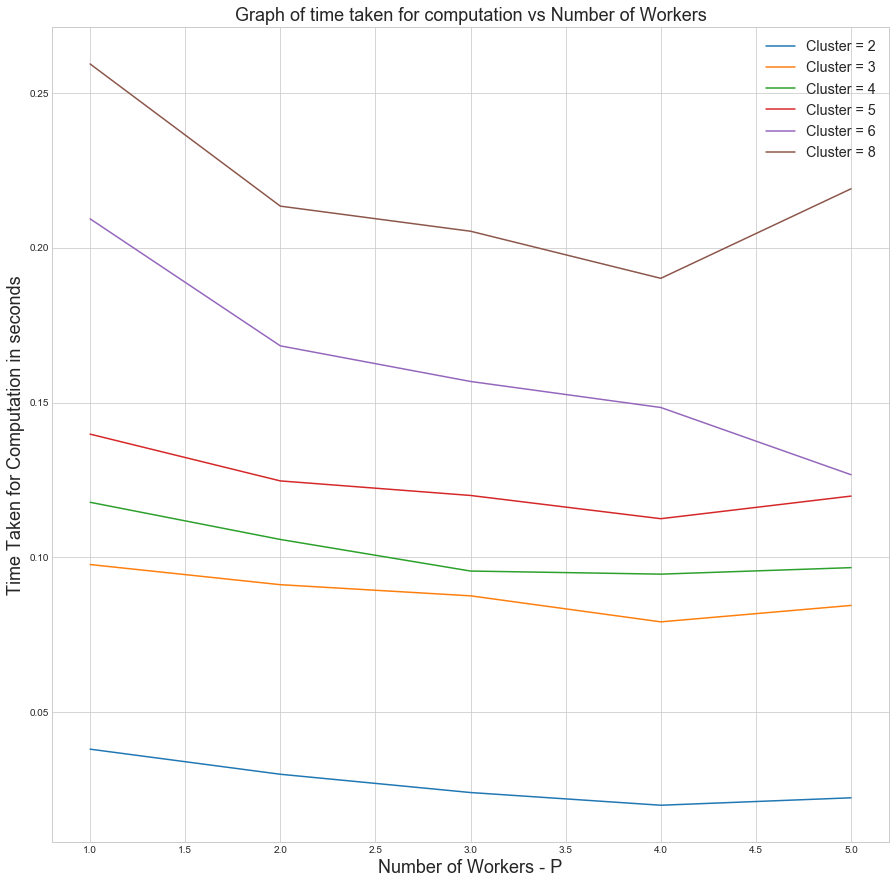

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,15)
sb.set_style ('whitegrid')

noWorkers  = [1,2,3,4,5]

Time4cluster2 = [0.0381, 0.0300, 0.0241, 0.0200,0.0224]
Time4cluster3 = [0.0977, 0.0912, 0.0876, 0.0792,0.0845]
Time4cluster4 = [0.1178, 0.1058, 0.0956, 0.0946,0.0967]
Time4cluster5 = [0.1398, 0.1247, 0.1200, 0.1125,0.1198]
Time4cluster6 = [0.2093, 0.1683, 0.1568, 0.1484,0.1267]
Time4cluster8 = [0.2593, 0.2134, 0.2053, 0.1901,0.2190]
 
plt.plot(noWorkers,Time4cluster2, label = "Cluster = 2" )
plt.plot(noWorkers,Time4cluster3, label = "Cluster = 3" )
plt.plot(noWorkers,Time4cluster4, label = "Cluster = 4" )
plt.plot(noWorkers,Time4cluster5, label = "Cluster = 5" )
plt.plot(noWorkers,Time4cluster6, label = "Cluster = 6" )
plt.plot(noWorkers,Time4cluster8, label = "Cluster = 8" )


plt.xlabel("Number of Workers - P", fontsize=18)
plt.ylabel("Time Taken for Computation in seconds", fontsize=18)
plt.yticks()
plt.title('Graph of time taken for computation vs Number of Workers', fontsize=18)
plt.legend(fontsize='x-large')

### Comment

From the graph, we noticed taht as the number of processes increase the time reduces till we get to 5 procrss that pattern change. This is bacause my computer have just 4 process.

## Resources 

https://www.datascience.com/blog/k-means-clustering
https://bl.ocks.org/rpgove/0060ff3b656618e9136b